In [274]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy.random as ra
import pandas as pd
import seaborn as sns
import scipy.constants as sc

import HERA_hack
import FG_hera

# Unresolved Point Source

Here we are generating average fluxes in each pixel due to a fixed number of sources per pixel. We do this using two pieces of information: 
1. Distribution of spectral indices of the sources
2. Source Count distribution

The method is the following: 
1. Draw n_sources number of spectral indices from a gaussian distribution
2. Draw n_soucres number of fiducial fluxes from the CDF of the source count distribution using **inverse transform sampling**. 
3. Compute the fluxes of each source and average over them.
4. Repeat for npix.

Text(0, 0.5, 'dn/d$S_*$')

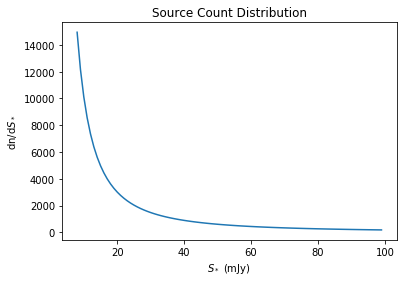

In [235]:
#differential source count 
gamma = 1.75

def dnds(s):
    return 4.*(s/880)**(-gamma)

s = np.arange(8,100,1)


#plt.loglog(s,dnds(s))
pdf = np.asarray([s,dnds(s)]) #0 is s, 1 is dnds

plt.plot(pdf[0],pdf[1])
plt.title('Source Count Distribution')
plt.xlabel('$S_*$ (mJy)')
plt.ylabel('dn/d$S_*$')

Text(0, 0.5, 'Probability')

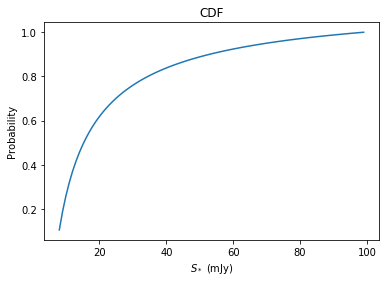

In [194]:
prob = pdf[1]/float(sum(pdf[1]))
cum_prob = np.cumsum(prob)
plt.plot(s,cum_prob)
plt.title('CDF')
plt.xlabel('$S_*$ (mJy)')
plt.ylabel('Probability')

Text(0, 0.5, 'dn/d$S_*$')

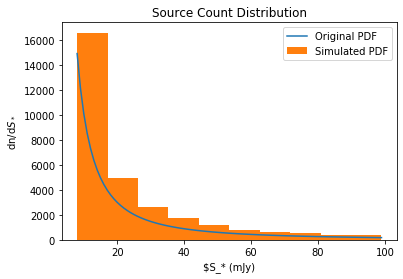

In [214]:

def gen_fluxes(N):
    R = ra.uniform(0, 1, N)
    #Here we first find the bin interval that random number lies in min(cum_prob[])
    #then we find the flux who's index is that cum_prob
    #repat for all r in R
    return [int(s[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]

N = 30000

plt.plot(pdf[0],pdf[1], label = 'Original PDF')
plt.hist(gen_fluxes(N), label = 'Simulated PDF')
plt.legend()
plt.title('Source Count Distribution')
plt.xlabel('$S_* (mJy)')
plt.ylabel('dn/d$S_*$')

In [215]:
dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])
HERA = HERA_hack.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')

obs = HERA_hack.observation(HERA, 100, 100, 0.01,acorner,1, 0.2, norm = False, pbeam = False)


#number of pixels in the map
npix =len(obs.observable_coordinates())



#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta



In [289]:
obs.Npix

1500

In [286]:
#integral over d_omega
theta_res = np.abs(np.cos(obs.observable_coordinates()[1,0])-np.cos(obs.observable_coordinates()[0,0]))
phi_res = obs.observable_coordinates()[30,1]- obs.observable_coordinates()[1,1]
omega_pix = theta_res*phi_res
##ADD COS THETAS int(cos(theta) dtheta dphi)! 
omega_pix

1.0846967597107002e-05

In [284]:
n_sources = 10
alpha_0 = 2.5
sigma = 0.5
freq = 100 #inherited
fiducial_freq = 150

pixel_flux = []

for i in range(npix):
    alpha = np.random.normal(alpha_0,sigma,n_sources)
    S_star = gen_fluxes(n_sources)
    sum_fluxes = 0 

    for i in range(n_sources-1):
        factor = 1.4e-6*((freq/fiducial_freq)**(-2))*(omega_pix**(-1))
        sum_fluxes += factor*S_star[i]*(freq/fiducial_freq)**(-alpha[i])
    
    pixel_flux.append(sum_fluxes/n_sources)



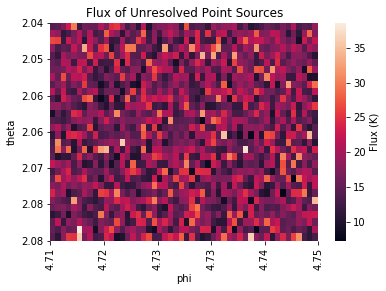

In [285]:

df_obs = pd.DataFrame.from_dict(np.array([x,y,pixel_flux]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Flux of Unresolved Point Sources', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# Galactic Synchrotron

For Galactic Synchrotron emission, we can create our field in a similar fashion to the unresolved point sources, except our Gaussian has mean spectral index $\alpha_{syn} = 2.8$ and standard deviation $\sigma_{syn} = 0.1$. We compute the flux in each pixel with a different randomly sampled $\alpha$ (Wang et al. 2006).

In [230]:

alpha_0_syn = 2.8
sigma_syn = 0.1
freq = 100 #inherited MHz
fiducial_freq = 150 #MHz
Asyn = 335.4 #K

pixel_flux_syn = []

alpha_syn = np.random.normal(alpha_0_syn,sigma_syn,npix)


for i in range(npix):
    flux = Asyn*(freq/fiducial_freq)**(-alpha_syn[i])
    pixel_flux_syn.append(flux)




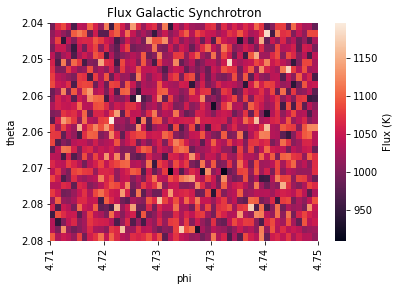

In [231]:
df_obs = pd.DataFrame.from_dict(np.array([x,y,pixel_flux_syn]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Flux Galactic Synchrotron', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# Free-Free Emission 

 For Galactic Synchrotron emission, we can create our field in a similar fashion to the unresolved point sources, except our Gaussian has mean spectral index $\alpha_{ff} = 2.15$ and standard deviation $\sigma_{ff} = 0.01$. We compute the flux in each pixel with a different randomly sampled $\alpha$ (Wang et al. 2006).

In [232]:

alpha_0_ff = 2.15
sigma_ff = 0.01
freq = 100 #inherited MHz
fiducial_freq = 150 #MHz
Aff = 33.5 #K

pixel_flux_ff = []

alpha_ff = np.random.normal(alpha_0_ff,sigma_ff,npix)


for i in range(npix):
    flux = Aff*(freq/fiducial_freq)**(-alpha_ff[i])
    pixel_flux_ff.append(flux)





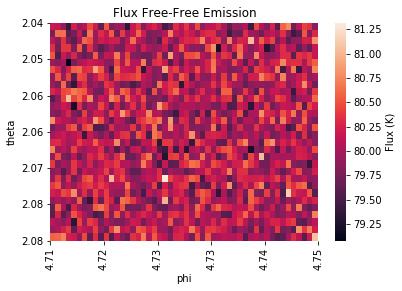

In [233]:
df_obs = pd.DataFrame.from_dict(np.array([x,y,pixel_flux_ff]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Flux Free-Free Emission', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# Total Foreground Flux

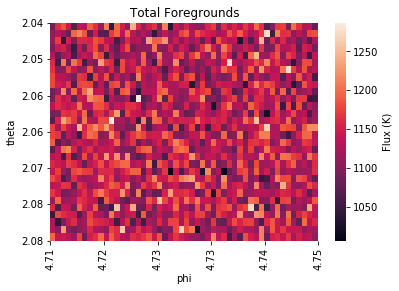

In [273]:
pixel_flux = np.asarray(pixel_flux)
pixel_flux_ff = np.asarray(pixel_flux_ff)
pixel_flux_syn = np.asarray(pixel_flux_syn)

total_fg = pixel_flux + pixel_flux_ff + pixel_flux_syn

df_obs = pd.DataFrame.from_dict(np.array([x,y,total_fg]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Total Foregrounds', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

In [287]:
np.savetxt('total_foregrounds.txt',total_fg)

In [296]:
freq_fid = 150
def generate_foregrounds():
############ SYNCHRO EMISSION ############

    alpha_0_syn = 2.8
    sigma_syn = 0.1
    Asyn = 335.4 #K

    pixel_flux_syn = []

    alpha_syn = np.random.normal(alpha_0_syn,sigma_syn,obs.Npix)

    for i in range(obs.Npix):
        flux = Asyn*(obs.freq/freq_fid)**(-alpha_syn[i])
        pixel_flux_syn.append(flux)




    ########### FREE FREE EMISSION ##########

    alpha_0_ff = 2.15
    sigma_ff = 0.01
    Aff = 33.5 #K

    pixel_flux_ff = []

    alpha_ff = np.random.normal(alpha_0_ff,sigma_ff,obs.Npix)

    for i in range(obs.Npix):
        flux = Aff*(obs.freq/freq_fid)**(-alpha_ff[i])
        pixel_flux_ff.append(flux)

    ########### UNRES POINT SOURCE ###########

    gamma = 1.75

    def dnds(s):
        return 4.*(s/880)**(-gamma)

    s = np.arange(8,100,1) #maybe make this an argument 

    pdf = np.asarray([s,dnds(s)]) #0 is s, 1 is dnds
    prob = pdf[1]/float(sum(pdf[1]))
    cum_prob = np.cumsum(prob)

    def gen_fluxes(N):
        R = ra.uniform(0, 1, N)
        #Here we first find the bin interval that random number lies in min(cum_prob[])
        #then we find the flux who's index is that cum_prob
        #repat for all r in R
        return [int(s[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]

    alpha_0 = 2.5
    sigma = 0.5

    theta_res = np.abs(np.cos(obs.observable_coordinates()[1,0])-np.cos(obs.observable_coordinates()[0,0]))
    phi_res = obs.observable_coordinates()[30,1]- obs.observable_coordinates()[1,1]
    omega_pix = theta_res*phi_res
    factor = 1.4e-6*((obs.freq/freq_fid)**(-2))*(omega_pix**(-1))

    pixel_flux = []

    for i in range(obs.Npix):
        alpha = np.random.normal(alpha_0,sigma,n_sources)
        S_star = gen_fluxes(n_sources)
        sum_fluxes = 0 

        for i in range(n_sources-1):
            sum_fluxes += factor*S_star[i]*(obs.freq/freq_fid)**(-alpha[i])

        pixel_flux.append(sum_fluxes/n_sources)


    ########## TOTAL FG ################

    pixel_flux = np.asarray(pixel_flux)
    pixel_flux_ff = np.asarray(pixel_flux_ff)
    pixel_flux_syn = np.asarray(pixel_flux_syn)
    
    total_fg = pixel_flux + pixel_flux_ff + pixel_flux_syn

    return total_fg

array([1074.98991426, 1124.52138897, 1152.25584523, ..., 1118.40097683,
       1179.61781067, 1170.33394501])